<a href="https://colab.research.google.com/github/ArturoSirvent/TFG_notebooks/blob/main/recomp_funcs/INCOMPLETO_programa_definitivo_revision_datos_CTA_9_2_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos a poner todas las funciones de analisis que he desarrollado, en un mismo script.

In [ ]:
#primero importamos las librerias fundamentales
#cargamos librerias 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import tensorflow as tf
import pandas as pd
import glob 
#estas no son esenciales
import re
#import shutil
#import zipfile as zip
#import gzip
#import sys

In [ ]:
#?? revisar
#funciones útiles

#lo primero que vamos a hacer es descomprimir los gunzip que tenemos
def descomprimir_gunzip(ground_dir,elementos,folders=True):
  #funcion para descomprimir los elementos gunzip
  #ground_dir es la carpeta padre de las otras carpetas o la contenedora de los datos talcual.
  #elementos son los [gamma,electron,silicium...]
  #folders true nos indica que hay carpetas contenedoras para cada elemento. I false, estan todos los datos
  #en el ground directory.
  if folders:
    for i in elements:
      element_dir=os.path.join(ground_dir,i)
      os.chdir(element_dir)
      files_names=glob.glob("*.dt.gz")
      new_files_names=[h.replace(".dt.gz",".dt") for h in files_names]
      for j in range(len(files_names)):
        with gzip.open(os.path.join(element_dir,files_names[j]),"rb") as f:
          fp=open(f"{}/new_files_names[j]","wb")
          aux=f.read()
          fp.write(aux)
          fp.close()
  else:
    for i in elements:
      os.chdir(ground_dir)
      files_names=glob.glob("{i}*.dt.gz")
      new_files_names=[h.replace(".dt.gz",".dt") for h in files_names]
      for j in range(len(files_names)):
        with gzip.open(os.path.join(ground_dir,files_names[j]),"rb") as f:
          fp=open(new_files_names[j],"wb")
          aux=f.read()
          fp.write(aux)
          fp.close()


In [ ]:
#creamos una funcion que coja un archivo dt y nos devuelva sus imagenes formateadas, junto con el numero del evento.
def events_and_images(dt_file_route):

In [ ]:
#?? revisar
def limpiar_datos(df_in):
  #vamos a crear una funcion para que se limpien y formateen los datos
  #le pasamos un dataframe de pandas y nos devolvera un dataframe modificado conforme a lo que queremos
  # o una lista con np arrays de esos datos, las imagenes
  df_aux=df_in.copy()
  df_aux["5"].loc[df_aux["5"]<0]=0
  max_aux=np.amax(value_auf["5"])
  df_aux["5"]=df_aux["5"]/max_aux
  x_minimo=min(df_aux['3'])
  y_minimo=min(df_aux['4'])
  df_aux['3']=df_aux['3'].apply(lambda x: round((x-x_minimo)/333))
  df_aux['4']=df_aux['4'].apply(lambda x: round((x-y_minimo)/192))
  #event_aux=df_aux["1"].unique()
  


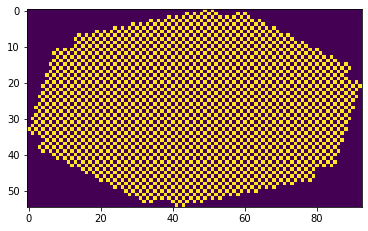

In [ ]:
aux_df=pd.read_csv("/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/electron/electron_tel_1_run_01.dt",sep='  ',names=["1","2","3","4","5","6"],engine="python")
#primero cargamos los datos y los separamos segun lso diferentes eventos, con que calculemos para uno en principio deberia ser suficiente
events=aux_df["1"].unique()
auxiliar=aux_df[aux_df["1"]==events[0]][["3","4","5"]].to_numpy()
miau=aux_df[aux_df["1"]==events[0]][["3","4","5"]]
#ahora tenemos los datos de los pixeles, podemos obtener lo que ocupa cada pixel
num_pix_x=miau["3"].unique().size
num_pix_y=miau["4"].unique().size
size_pix_x=np.ceil((max(auxiliar[:,0])-min(auxiliar[:,0]))/(np.unique(auxiliar[:,0]).size-1))
size_pix_y=np.ceil((max(auxiliar[:,1])-min(auxiliar[:,1]))/(np.unique(auxiliar[:,1]).size-1))
miau["5"]=10

miau['3']=miau['3'].apply(lambda x: round((x-min(miau["3"]))/size_pix_x)).to_numpy()
miau['4']=miau['4'].apply(lambda x: round((x-min(miau["4"]))/size_pix_y)).to_numpy()
matrix_aux=np.zeros((num_pix_x,num_pix_y)) #eran 60-5= 55 y 131-38
matrix_aux[miau["3"].to_numpy(),miau["4"].to_numpy()]=miau["5"].to_numpy() #el 5 y el 39 ese me suenan raro, el 39 sobretodo
plt.imshow(matrix_aux)

In [ ]:
#ahora vamos a hacer una funcion para el tratamiento de los datos de .dt a un .npy con los datos limpios y agrupaditos de una forma mas sencilla.

#tenemos que buscar una forma de que no guardemos archivos npy de mas de un giga (por poner un limite)
from tqdm.notebook import tqdm

def multiple_dt_2_npy(ground_dir,npy_dir,elements,folders=True,limit_size=0.35,save_events_id=False):
  #ground_dir es el directorio base para las carpetas o para los archivos
  #npy_dir es el directorio para guardar todosl os .npy juntos, sin fantasia ni carpetas
  #folders=True es que los elementos .dt estan en carpetas
  #limit_size limite de peso en gigas de los .npy, por defecto esat en 350 Mb ó 0.35 Gigas

  #le añadimos la funcion de que cree un archivo que registra el identificador de cada evento, guardado en el mismo orden que las imagenes

  limit_size=limit_size*1e9 # pasamos de gigas a bytes 
  #tenemos que crear el directorio si aun no existe
  npy_dir_aux=npy_dir
  k=0
  while os.path.isdir(npy_dir_aux):
    k+=1
    npy_dir_aux=npy_dir+f"_{k}"
  if not os.path.isdir(npy_dir_aux):
    os.mkdir(npy_dir_aux)

  for elements_dt in elements:
    contador_nombre=0
    if folders:
      element_dir=os.path.join(ground_dir,elements_dt)
      os.chdir(element_dir)
      files_names=glob.glob("*.dt")
    else:
      element_dir=ground_dir
      os.chdir(element_dir)
      files_names=glob.glob(f"{elements_dt}*.dt")
    #creamos una lista con un dataframe por cada archivo
    dt_list=[]  
    for j in range(len(files_names)):
      print(j,end="\n")
      aux_df=pd.read_csv(os.path.join(element_dir,files_names[j]),sep='  ',names=["1","2","3","4","5","6"],engine="python")
      #ahora la procesamos y la guardamos en un npy
      value_auf=aux_df[['1','3','4','5']].copy()
      del aux_df
      #tenemos que agupar los valores y normalizarlos 
      value_auf["5"].loc[value_auf["5"]<0]=0
      max_aux=np.amax(value_auf["5"])
      value_auf["5"]=value_auf["5"]/max_aux
      x_minimo=min(value_auf['3'])
      y_minimo=min(value_auf['4'])
      if j==0: #esto lo hacemos porque todos los evento deben ser iguales del mismo telescopio, si no no es valido
        events=value_auf["1"].unique()
        num_pix_x=value_auf["3"].unique().size
        num_pix_y=value_auf["4"].unique().size

        auxiliar=value_auf[value_auf["1"]==events[0]][["3","4","5"]].to_numpy()
        #ahora tenemos los datos de los pixeles, podemos obtener lo que ocupa cada pixel
        size_pix_x=np.ceil((max(auxiliar[:,0])-min(auxiliar[:,0]))/(np.unique(auxiliar[:,0]).size-1))
        size_pix_y=np.ceil((max(auxiliar[:,1])-min(auxiliar[:,1]))/(np.unique(auxiliar[:,1]).size-1))
        del auxiliar
      value_auf['3']=value_auf['3'].apply(lambda x: round((x-x_minimo)/size_pix_x))
      value_auf['4']=value_auf['4'].apply(lambda x: round((x-y_minimo)/size_pix_y))
      #event_aux=value_auf["1"].unique()
      for k in tqdm(range(np.shape(events)[0])):
        #cada evento tiene que ponerse en una imagen con sus valores
        array_aux=value_auf.loc[value_auf["1"]==events[k]][["3","4","5"]]
        #lo que vamos a hacer es poner los valores en una matriz creada de antemano y guardar esa matrix
        #esos numeros vienen del maximo y el minimo valor para los pixeles, simplemente shifteamos todo
        matrix_aux=np.zeros((num_pix_x,num_pix_y)) #eran 60-5= 55 y 131-38
        matrix_aux[array_aux["3"].to_numpy(),array_aux["4"].to_numpy()]=array_aux["5"].to_numpy() 
        dt_list.append(matrix_aux)
        if limit_size!=0:
          if (np.array(dt_list).nbytes>limit_size):
            name_npy=os.path.join(npy_dir_aux,f"{elements_dt}_{contador_nombre}.npy")
            np.save(name_npy,np.array(dt_list))
            del dt_list
            dt_list=[]
            contador_nombre+=1

    name_npy=os.path.join(npy_dir_aux,f"{elements_dt}_{contador_nombre}.npy")
    np.save(name_npy,np.array(dt_list))
    if save_events_id:
      name_npy_events=os.path.join(npy_dir_aux,f"id_eventos{elements_dt}_{contador_nombre}.npy")
      np.save(name_npy_events,np.array(events))



In [ ]:
def analisis_sencillo_dir(npy_file,savedir=None):
  datos=np.load(npy_file)
  matrix_aux=sum(datos)
  plt.figure(figsize=(14.5,11)) #cambio
  plt.imshow(matrix_aux,aspect="auto")
  #vamos a poner el porcentaje que esta por encima de la media
  matrix_aux_non0=matrix_aux[matrix_aux!=0]
  min_aux=np.amin(matrix_aux_non0)
  max_aux=np.amax(matrix_aux_non0)
  media=np.mean(matrix_aux_non0.flatten())
  #ahora necesitamos enlazar los colores del minimo que no es cero y del maximo, con los porcentajes
  plt.colorbar(values=np.linspace(min_aux,max_aux,100),ticks=[0,min_aux,media,max_aux]).set_label(label='Intensidad',size=25)
  plt.clim(min_aux/3,max_aux)
  if savedir is None:
    plt.show()
  else:
    plt.savefig(savedir)
  plt.close()


def analisis_sencillo_array(matrix,savedir=None):
  plt.figure(figsize=(14.5,11)) #cambio
  plt.imshow(matrix,aspect="auto")

  #vamos a poner el porcentaje que esta por encima de la media
  matrix_aux_non0=matrix[matrix!=0]
  min_aux=np.amin(matrix_aux_non0)
  max_aux=np.amax(matrix_aux_non0)
  media=np.mean(matrix_aux_non0.flatten())
  #ahora necesitamos enlazar los colores del minimo que no es cero y del maximo, con los porcentajes
  plt.colorbar(values=np.linspace(min_aux,max_aux,100),ticks=[0,min_aux,media,max_aux]).set_label(label='Intensidad',size=25)
  plt.clim(min_aux/3,max_aux)
  if savedir is None:
    plt.show()
  else:
    plt.savefig(savedir)
  plt.close()


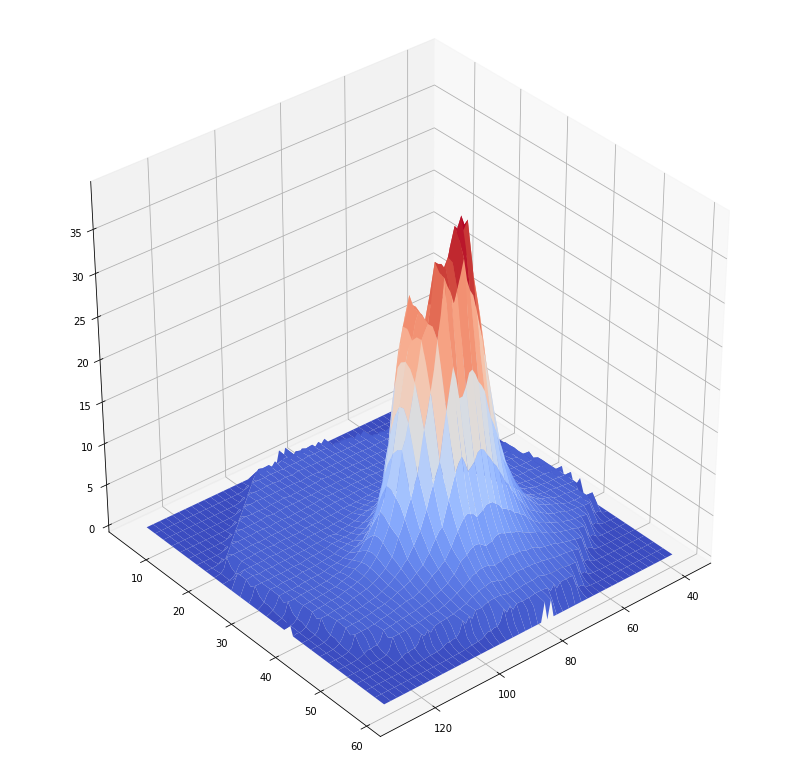

In [ ]:
#npy_file="/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/npy archivos/each_run/gamma_run_12.npy"
#datos=np.load(npy_file)
#matrix_aux=sum(datos)
##analisis_sencillo_dir(npy_file)
#rep_npy_3d(npy_file)

In [ ]:
#ahora ya tenemos los datos en arrays de python y ordenados. Podemos definir funciones para que se analicen estadisticamente los datos
def analisis_total(npy_dir,stats_dir,elementos,percentiles=[75,85,99.9]):
  #un mapa de calor de todas las runs de los elementos datos
  os.chdir(npy_dir)
  for k in elementos:
    lista_elementos=glob.glob("{k}*.npy")

    for i in range(len(lista_elementos)):
      try:
        del datos
        del datos_aux
      except:
        pass

      datos=np.load(os.path.join(npy_dir,lista_elementos[i]))
      nombre_aux=lista_elementos[i].replace(".npy","")
      nombre_aux_suma_img="suma_total_"+nombre_aux
      matrix_aux=sum(datos.copy())

      plt.figure(figsize=(17,14))
      plt.subplot(3,3,2)
      plt.imshow(matrix_aux,aspect="auto")
      #necesitamos la media de intensidad de aquellos que no son 0
      matrix_aux_non0=matrix_aux[matrix_aux!=0]
      min_aux=np.amin(matrix_aux_non0)
      max_aux=np.amax(matrix_aux_non0)
      media=np.mean(matrix_aux_non0.flatten())
      del matrix_aux_non0
      del matrix_aux
      plt.colorbar(values=np.linspace(min_aux,max_aux,100),ticks=[0,min_aux,media,max_aux]).set_label(label='Intensidad',size=10)
      plt.clim(min_aux/3,max_aux)
      plt.title(nombre_aux_suma_img,fontsize=14)
      #lo hacemos tambien para las indicendias totales, aquellas que superan un humbral

      #ahora calculamos los percentiles
      perc=["perc{percentiles[0]}","percpercentiles[1]","percpercentiles[2]"]
      vals_perc=[np.percentile(datos,percentiles[0]),np.percentile(datos,percentiles[1]),np.percentile(datos,percentiles[2])]
      for j in range(len(perc)):
        datos_aux=datos.copy()
        nombre_aux_perc_img="suma_"+perc[j]+"_"+nombre_aux
        datos_aux[datos<vals_perc[j]]=0
        matrix_aux=sum(datos_aux)
        plt.subplot(3,3,4+j)
        matrix_aux_non0=matrix_aux[matrix_aux!=0]
        min_aux=np.amin(matrix_aux_non0)
        max_aux=np.amax(matrix_aux_non0)
        media=np.mean(matrix_aux_non0.flatten())
        plt.imshow(matrix_aux,aspect="auto")

        plt.colorbar(values=np.linspace(min_aux,max_aux,100),ticks=[0,min_aux,media,max_aux]).set_label(label='Intensidad',size=10)
        plt.clim(min_aux/3,max_aux)
        plt.title(nombre_aux_perc_img,fontsize=14)
        #lo hacemos tambien para las indicendias totales, aquellas que superan el percentil, las ponemos 
        #a valor 1 independientemente, y luego sumamos
        datos_aux=datos.copy()
        datos_aux[datos>=vals_perc[j]]=1.0
        datos_aux[datos<vals_perc[j]]=0
        matrix_aux=sum(datos_aux)
        nombre_aux_perc_img="incidencia_"+perc[j]+"_"+nombre_aux
        plt.subplot(3,3,7+j)
        matrix_aux_non0=matrix_aux[matrix_aux!=0]
        min_aux=np.amin(matrix_aux_non0)
        max_aux=np.amax(matrix_aux_non0)
        media=np.mean(matrix_aux_non0.flatten())
        plt.imshow(matrix_aux,aspect="auto")
        del matrix_aux_non0
        del matrix_aux
        plt.colorbar(values=np.linspace(min_aux,max_aux,100),ticks=[0,min_aux,media,max_aux]).set_label(label='Fotones incidentes',size=10)
        plt.clim(min_aux/3,max_aux)
        plt.title(nombre_aux_perc_img,fontsize=14)
      plt.tight_layout()
      plt.savefig(os.path.join(stats_dir,nombre_aux)+"_con_escala.png")
      plt.close()

In [ ]:
npy="/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/npy archivos/iron.npy"
datos=np.load(npy)


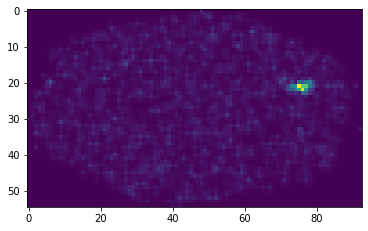

In [ ]:
a=fill_holes(datos[8],valores_x_pix,valores_y_pix)
plt.imshow(a)

In [ ]:
#creamos una funcion para que nos devuelva los valoes de los pixeles usados,
#dato un archivo dt
def pos_pixels(dt_file):
  aux_df=pd.read_csv(dt_file,sep='  ',names=["1","2","3","4","5","6"],engine="python")
  #primero cargamos los datos y los separamos segun lso diferentes eventos, con que calculemos para uno en principio deberia ser suficiente
  events=aux_df["1"].unique()
  auxiliar=aux_df[aux_df["1"]==events[0]][["3","4"]].to_numpy()
  miau=aux_df[aux_df["1"]==events[0]][["3","4"]]
  del aux_df

  size_pix_x=np.ceil((max(auxiliar[:,0])-min(auxiliar[:,0]))/(np.unique(auxiliar[:,0]).size-1))
  size_pix_y=np.ceil((max(auxiliar[:,1])-min(auxiliar[:,1]))/(np.unique(auxiliar[:,1]).size-1))
  miau['3']=miau['3'].apply(lambda x: round((x-min(miau["3"]))/size_pix_x)).to_numpy()
  miau['4']=miau['4'].apply(lambda x: round((x-min(miau["4"]))/size_pix_y)).to_numpy()
  return (np.sort(miau['3'].unique()),np.sort(miau['4'].unique()))

In [ ]:
pos

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92]))

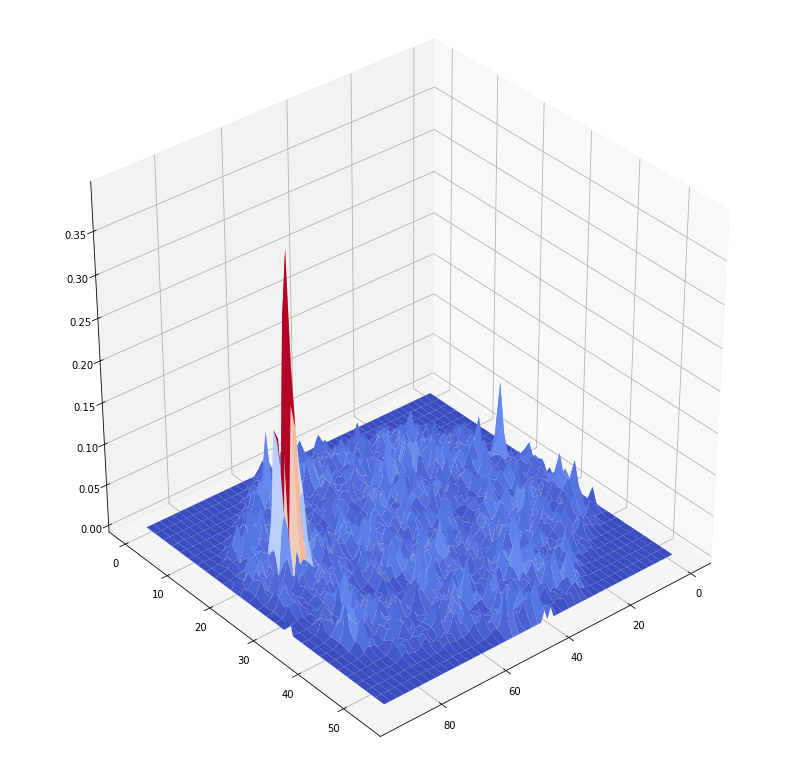

In [ ]:
dt_dir="/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/proton/proton_tel_1_run_01.dt"
pos=pos_pixels(dt_dir)
np_dir="/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/npy archivos/proton.npy"
rep_npy_3d(datos[8],pos[0],pos[1])


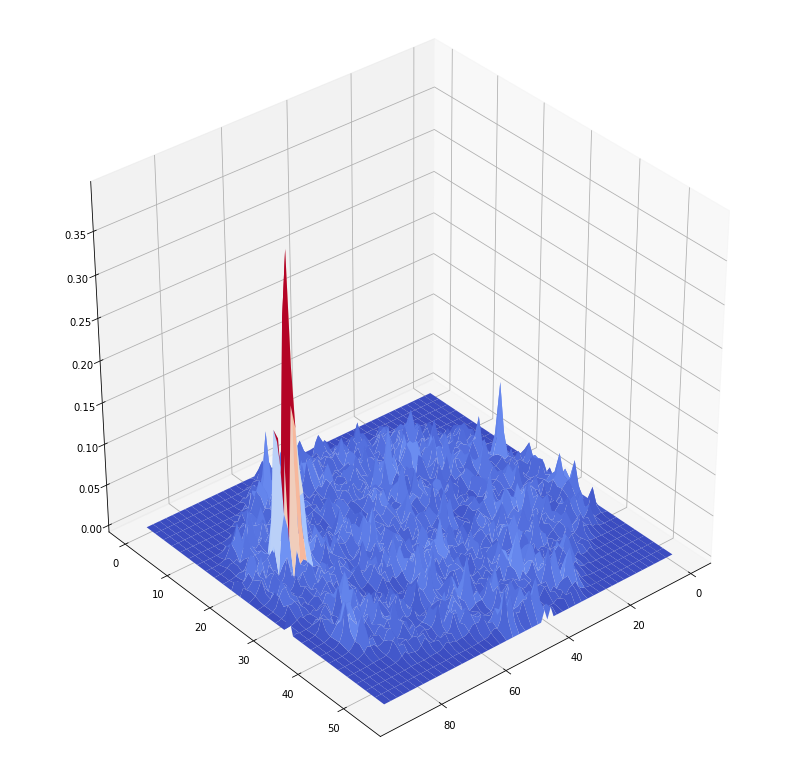

In [ ]:
rep_npy_3d(datos[8],valores_x_pix,valores_y_pix)


In [ ]:
def fill_holes(npy_file,x,y):
  #dado un archivo npy representamos el mapa de calor relleno con la media de sus vecinos
  #puede ser tambien un array y ya esta
  if type(npy_file)==str:
    datos=np.load(npy_file)
    matrix_aux=sum(datos)
  elif type(npy_file)==np.ndarray:
    matrix_aux=npy_file
  else:
    print("error")
    return
  valores_y_pix=y
  valores_x_pix=x
  """
  valores_x_pix=[5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 
                18., 19., 20., 21., 22.,23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 
                41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59.] 
  valores_y_pix=[38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,
                 52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
                 66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
                 80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
                 94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
                 108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
                 122., 123., 124., 125., 126., 127., 128., 129., 130.]
  """
  #segun el telescopio los puntos de los pixeles cambian
  #dada una npy file



  a=np.where(matrix_aux==0)
  c=np.dstack([a[0],a[1]])
  c=np.squeeze(c) #esta funcion esta para reducir dimensiones para esos casos que se te queda [[[1,23,4],[1,2,54]]], aqui nos sobra una
  for i,j in c:
    if (i!= int(valores_x_pix[0])) and (i!= int(valores_x_pix[-1])) and (j!= int(valores_y_pix[0])) and (j!= int(valores_y_pix[-1])):
      val_medio_aux=(matrix_aux[i-1,j]+matrix_aux[i+1,j]+matrix_aux[i,j-1]+matrix_aux[i,j+1])/4
      matrix_aux[i,j]=val_medio_aux

  return matrix_aux

In [ ]:
#ahora representamos en 3D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
def rep_npy_3d(npy_file,x,y,end_dir="/content/drive/MyDrive/rep_3d_archivo_npy.png",showfig=True,savefig=False):
  matriz=fill_holes(npy_file,x,y)
  valores_y_pix=y
  valores_x_pix=x 
  """ 
  valores_x_pix=[5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 
                18., 19., 20., 21., 22.,23., 24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 
                41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59.] 
  valores_y_pix=[38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,
                 52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
                 66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
                 80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
                 94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
                 108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
                 122., 123., 124., 125., 126., 127., 128., 129., 130.]
  """
  XX,YY=np.meshgrid(valores_y_pix,valores_x_pix)
  fig = plt.figure(figsize=(14,14))
  ax = fig.gca(projection='3d')
  surf = ax.plot_surface(XX, YY, matriz, cmap=cm.coolwarm)
  ax.view_init(elev=35,azim=50)
  if savefig:
    plt.savefig(end_dir)
  if showfig:
    plt.show()
  plt.close()


In [ ]:
def im_latex_names(lista_nombres_imagenes,ancho=17,print=False):
  nombres=[]
  for i in lista_nombres_imagenes:
    aux="\includegraphics[width="+str(ancho)+" cm]{"+str(i)+"} \n"
    nombres.append(aux)
    if print:
      print(aux)

  return " ".join(nombres)

In [ ]:
def hex_repre(matrix=None,npy_file=None,savedir=None):
  if npy_file is None and matrix is not None:
    matrix_aux=matrix
  elif npy_file is not None and matrix is None:
    datos=np.load(npy_file)
    matrix_aux=sum(datos)
  else:
    print("Error, debes pasar solo una de las dos cosas, matriz o ruta de archivo.")
    return
  plt.figure(figsize=(14,14))
  plt.scatter(*matrix_aux.nonzero(),s=125,c=matrix_aux[matrix_aux.nonzero()],marker="H",cmap="binary",alpha=0.85)
  if savedir is None:
    plt.show()
  else:
    plt.savefig(savedir)
  plt.close()

In [ ]:
#ahora vamos a hacer unas funciones para el analisis de los datos del archivo .txt
def extract_info_txt(txt_dir,cols=None,cols_order=True):
  #extraer la informacion relevante de un archivo .txt
  #si se le pasan ciertas columnas se devolvera una lista solo con esas columnas
  with open(txt_dir,"r") as file:
    text_aux=file.read()
  a=re.findall(r'@\+[\s\d.-]*\d',text_aux)
  a=[i.replace("@+ ","").split() for i in a]
  if cols is None:
    return a 
  elif type(cols)==list or type(cols)==np.array:
    list_aux=[]
    if cols_order :
      for i in cols:
        list_aux.append(np.array([float(j[i]) for j in a]))
      return np.array(list_aux)
    else:
      list_aux=[]
      for i in a:
        list_aux.append(np.array([i[j] for j in cols ]))
      return np.array(list_aux)

  else:
    return np.array([float(j[cols]) for j in a])




In [ ]:
#control+ Y es para rehacer una accion

In [ ]:
#para un directorio con muchos archivos .txt
def extract_info_txt_dir(main_dir,cols=None):
  list_aux=glob.glob(main_dir+"/*.txt")
  datos_aux=[]
  for i in list_aux:
    datos_aux.append(extract_info_txt(i,cols=cols))

  return datos_aux #np.squeeze(np.array(datos_aux,dtype=object))

In [ ]:
def hist_txt(columna: int,dir_o_file,bins=100,xlim=None,end_file=None):
  #esta funcion hace un histograma de uno o varios archivos txt, data la cantidad/columna deseada
  if os.path.isfile(dir_o_file):
    datos_aux=extract_info_txt(dir_o_file,cols=columna)
    plt.figure(figsize=(12,12))
    plt.hist(datos_aux,histtype='step',bins=bins, alpha=0.85)
    plt.title(f"Histogram for column {columna}",fontsize=14)
    plt.xlabel(f"Column {columna} values",fontsize=14)
    if xlim is not None:
      plt.xlim(xlim)
    if end_file is None:
      plt.show()
      plt.close()
    else:
      plt.savefig(end_file)
      plt.close()
  elif os.path.isdir(dir_o_file):
    datos_aux=extract_info_txt_dir(dir_o_file,cols=columna)
    plt.figure(figsize=(12,12))
    for i in datos_aux:
      plt.hist(i,histtype='step',bins=bins, alpha=0.235)

    plt.title(f"Histogram for column {columna}",fontsize=14)
    plt.xlabel(f"Column {columna} values",fontsize=14)
    if xlim is not None:
      plt.xlim(xlim)
    if end_file is None:
      plt.show()
      plt.close()
    else:
      plt.savefig(end_file)
      plt.close()

In [ ]:
#solo queda hacer una funcion para que se agrupen los valores segun los diferentes valores que pueden tomar las columnas y asi que se haya un mapa de calor

#ahora voy a poner un intervalo para las energias y segun si un proceso ocurre en ese intervalo, lo incluyo en una lista
#ese intervalo de energías lo obtenemos de hacer histogram con los datos de TODAS LAS RUNS.
#VAMOS A JUNTAR RUNS PUES SUPONEMOS QUE EL ERROR NO ESTAN EN NINGUNA DE ELLAS EN CONCRETO


def group_by_txt_value(dt_dir,txt_dir,columna,npy_dir=None,graph_dir=None,names=None,n_of_bins=16,save_npy_run=False,save_npy_total=False,
                       graph_save_run=False,graph_save_all=False,graph_show_run=False,graph_show_all=True):
  #esta funcion esta dada para hacer una agrupacion de los datos segun intervalos dados por los archivos .txt
  #la clasificacion se hacen 16 bins en principio

  os.chdir(dt_dir)
  archivos_dt=glob.glob("*.dt")
  archivos_dt=[i.replace(".dt","") for i in archivos_dt]
  os.chdir(txt_dir)
  archivos_txt=glob.glob("*.txt")
  archivos_txt=[i.replace(".txt","") for i in archivos_txt]
  if names is None:
    if set(archivos_dt)!=set(archivos_txt):
      print("Error, no hay los mismo dt que txt, pero tomamos los que sean iguales y seguimos adelante")
      archivos_def=list(set(archivos_txt).intersection(set(archivos_dt)))
    else:
      archivos_def=archivos_dt #por poner uno
  else:
    if (not set(names).issubset(set(archivos_dt))) or (not set(names).issubset(set(archivos_txt))):
      print("Uno de los nombres no esta.")
      return
    else:
      archivos_def=names
  primero=True

  side=np.ceil(np.sqrt(n_of_bins))
  #valores de las posiciones de los pixeles
  y=[32, 33, 31,  0, 30, 34, 29, 35, 28, 36, 27, 37, 26, 38, 25, 39, 24,40, 23, 41,
    22, 21, 20, 42, 43, 44, 19, 18, 45, 46, 17, 16, 47, 48,15, 14, 49, 50, 13, 12,
    51, 52, 11, 10, 53, 54,  9,  8, 55, 56, 7,6, 57, 58,  5, 59]
  x=[ 84,  82,  83,  85,  86,   0,  89,  87,  88,  90,  91,  79,  77, 78,  80,  81,
    94,  92,  95,  96,  93,  74,  72,  73,  75,  76, 99,  97,  98, 100, 101,  69,
    67,  68,  70,  71, 104, 102, 103,105, 106,  64,  62,  63,  65,  66, 109, 107,
    108, 110, 111,  59, 57,  58,  60,  61, 114, 112, 113, 115, 116,  54,  52,  53,
    55, 56, 119, 117, 118, 120, 121,  49,  47,  48,  50,  51, 123, 125,126,  44,
    42,  43,  45, 122, 124, 127,  46,  40,  38,  39,  41,128, 129, 130]

  clasificacion_sumatotal=[ np.zeros((60-5,131-38)) for i in range(n_of_bins)]

  for name in archivos_def:
    clasificacion=[ np.zeros((60-5,131-38)) for i in range(n_of_bins)]
    #vamos a extraer la informacion de cada una de las runs a la vez 
    #y vamos a unirla/agruparla segun la energia los eventos
    dt_file=os.path.join(dt_dir,name+".dt")
    dt_data=pd.read_csv(dt_file,sep='  ',names=["1","2","3","4","5","6"],engine="python")
    #procesamos los valores y despues clasificamos
    dt_data=dt_data[['1','3','4','5']].copy()
    dt_data.loc[dt_data["5"]<0]=0
    max_aux=np.amax(dt_data["5"])
    dt_data["5"]=dt_data["5"]/max_aux
    x_minimo=min(dt_data['3'])
    y_minimo=min(dt_data['4'])
    dt_data['3']=dt_data['3'].apply(lambda x: round((x-x_minimo)/333))
    dt_data['4']=dt_data['4'].apply(lambda x: round((x-y_minimo)/192))

    with open(os.path.join(txt_dir,name+".txt")) as txt_file:
      txt_data=txt_file.read()

    txt_data=re.findall(r'@\+[\s\d.-]*\d',txt_data)
    txt_data=[i.replace("@+ ","").split() for i in txt_data]
    txt_data=np.array([np.array([i[0],i[columna]],dtype=float) for i in txt_data])
    #esto lo vamos a hacer para el primero
    if (primero==True):
      #con esto estamos haciendo la suposicion de que mas o menos todas las energias tienen el mismo rango y con esto podemos clasificar casi todo
      #esta creencia esta fundamentada por la representacion que vemos de todas las runs, que son casi iguales las energias.
      primero=False
      ordenacion=np.histogram(txt_data[:,1],bins=n_of_bins)
      #plt.hist([i[1] for i in energias],30);
      edges=ordenacion[1]
    #ahora vamos a ordenar segun los edges
    #for num_evento, val_energia in energias:
    #tenemos que ver en que intervalo está la energia de este evento
    #creo que esto con histogram se puede hacer muy facil
    for i in range(n_of_bins):
      minim=edges[i]
      maxim=edges[i+1]
      #ahora vemos cuales de los eventos estan entre estas energias
      eventos_aux=txt_data[:,0][(txt_data[:,1]>minim) & (txt_data[:,1]<maxim)]
      #ahora tenemos que meter esos eventos en el array clasificación
      for event in eventos_aux:
        #ahora vamos a crear una imagen
        matrix_aux=np.zeros((60-5,131-38))
        data_aux=dt_data[dt_data["1"]==event][["3","4","5"]]
        matrix_aux[data_aux["3"].to_numpy()-5,data_aux["4"].to_numpy()-39]=data_aux["5"].to_numpy()
        #clasificacion[i].append(matrix_aux)
        clasificacion[i]+=matrix_aux
        clasificacion_sumatotal[i]+=matrix_aux
    #ya tenemos clasificacion que es una lista con todos los eventos clasificados segun energias
    #SEGUIMOS EN CADA UNA DE LAS RUNS, ahora vamos a hacer varias cosas, para todas las run, para cada una ...
    #primero de nada vamos a guardar los datos
    #guardamos los limites de energia y guardamos las imagenes de eventos en dichos intervalos
    #agrupacion_npy_energia
    run=int(re.findall(r"run_([0-9]*)",name)[0])
    if save_npy_run:
      #np.save(agrupacion_npy_energia+"/intervalos_de_phi_RUN_"+str(RUN)+".npy",edges) #esto solo se guarda una vez
      np.save(npy_dir+"/sucesos_RUN_"+str(run)+"_agrupados_segun_columna"+str(columna)+".npy",np.array(clasificacion))
    if graph_show_run or graph_save_run:
      plt.figure(figsize=(18,13))
      for i in range(n_of_bins):
        #esto depende el numero de bins, se han tomado 16 para que sea 4 y 4
        plt.subplot(side,side,i+1)
        plt.title(f"Sucesos de la RUN {run} para la \n columna {columna} entre valores \n {round(edges[i],3)} y {round(edges[i+1],3)}",fontsize=14)
        plt.imshow(clasificacion[i])
        plt.xticks([])
        plt.yticks([])
      plt.tight_layout()
      if graph_save_run:
        dir_graph=os.path.join(graph_dir,f"agrupacion_por_columna_{columna}_RUN_{run}.png")
        plt.savefig(dir_graph)
      if graph_show_run:
        plt.show()
      plt.close()

  if save_npy_total:
    np.save(npy_dir+"/sucesos_total_agrupados_segun_columna"+str(columna)+".npy",np.array(clasificacion_sumatotal))
  if graph_save_all or graph_show_all:
    plt.figure(figsize=(18,13))
    for i in range(n_of_bins):
      plt.subplot(side,side,i+1)
      plt.title(f"Sucesos totales para columna {columna} \n entre {round(edges[i],3)} y {round(edges[i+1],3)}",fontsize=14)
      plt.imshow(clasificacion_sumatotal[i])
      plt.xticks([])
      plt.yticks([])
    plt.tight_layout()
    if graph_save_all:
      dir_graph=os.path.join(graph_dir,f"clasificacion_total_columna_{columna}.png")
      plt.savefig(dir_graph)
    if graph_show_all:
      plt.show()
    plt.close()




In [ ]:
#direct="/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/gamma_txt"
#lista=[i.replace(".txt","") for i in os.listdir(direct)]
#names=lista[:5]
#names

In [ ]:
#def group_by_txt_value(dt_dir,txt_dir,columna,npy_dir,graph_dir,names=None,n_of_bins=16,save_npy_run=False,save_npy_total=False,
#                       graph_save_run=False,graph_save_all=False,graph_show_run=False,graph_show_all=True):

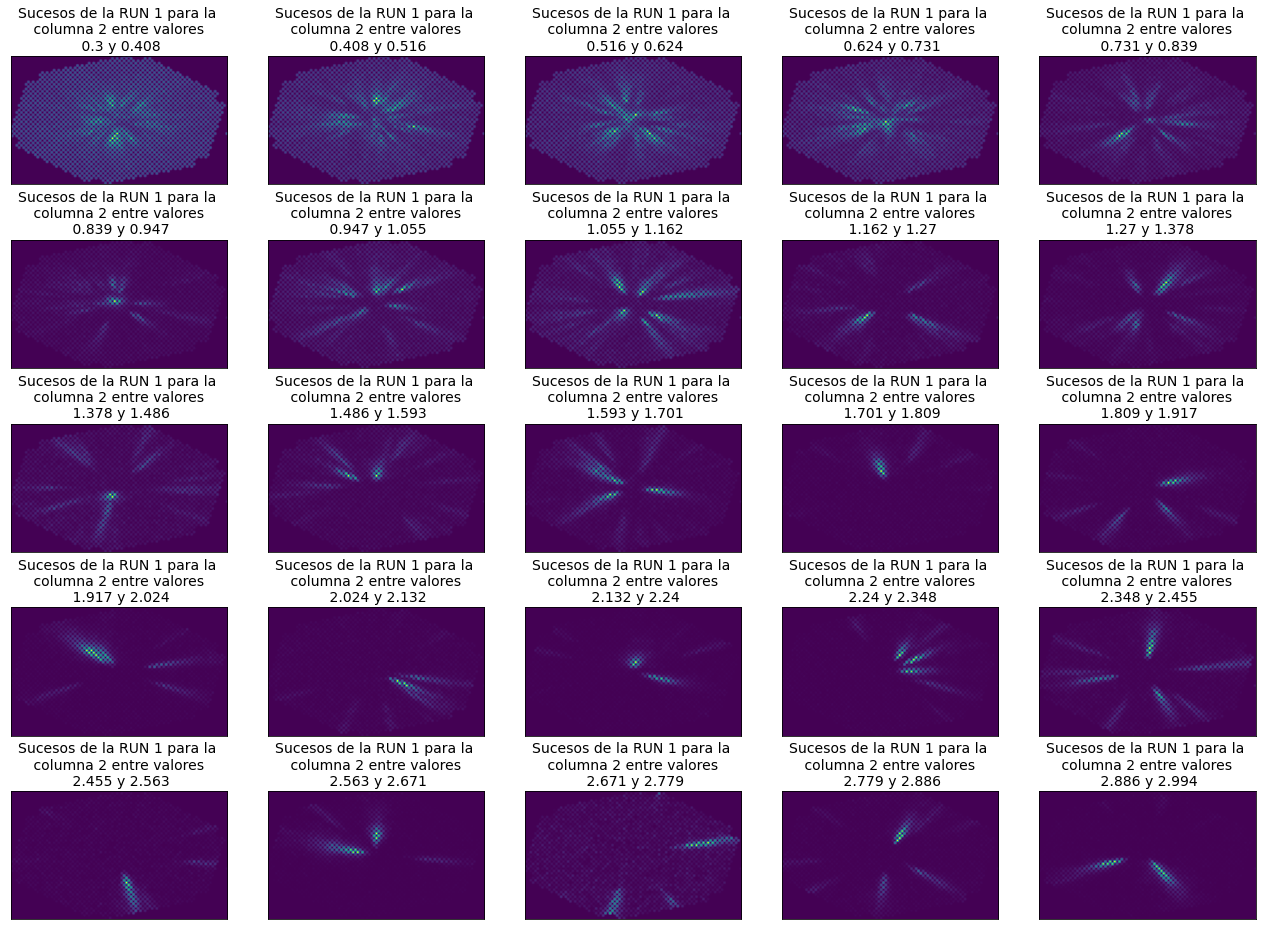

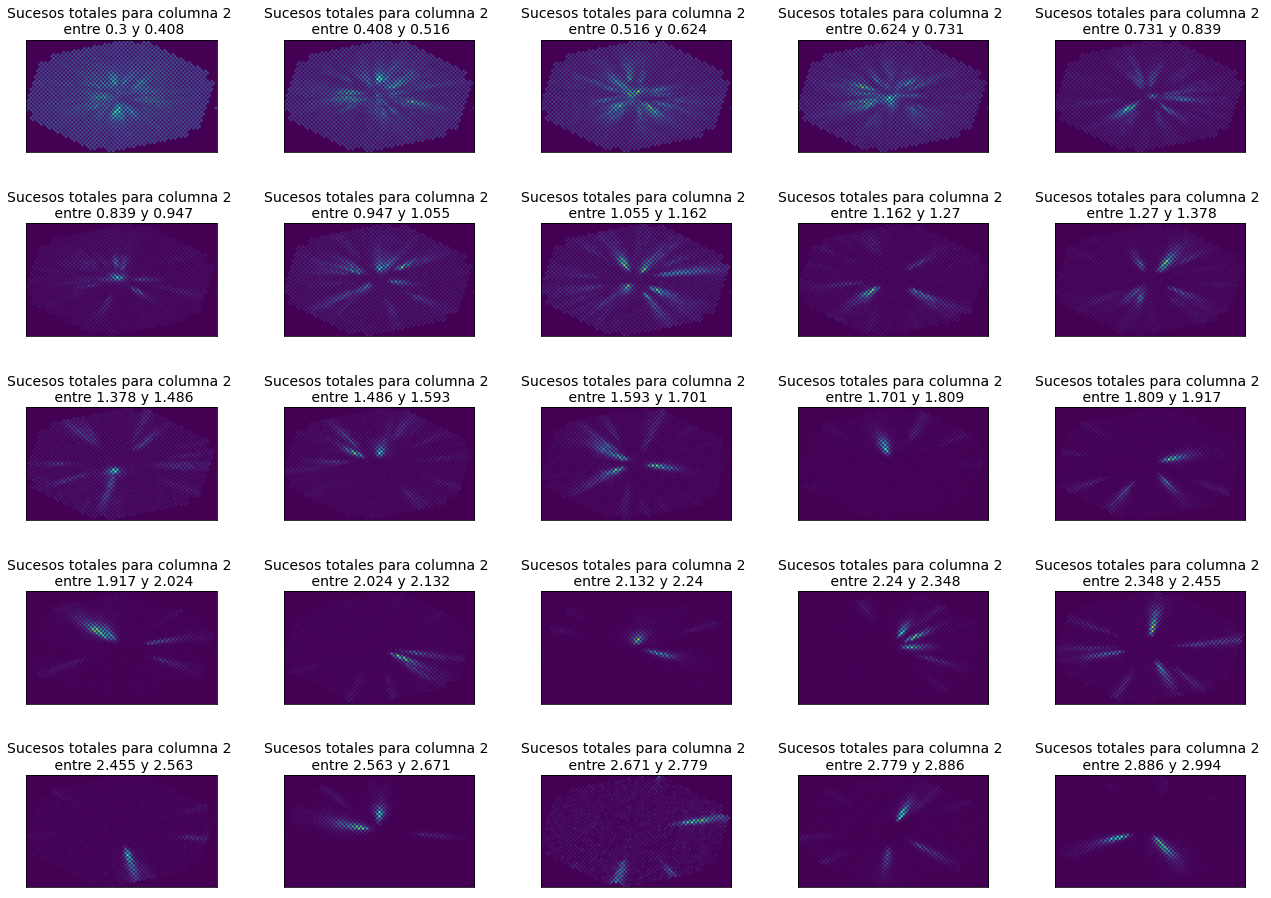

In [ ]:
#dt_dir="/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/gamma/gamma_dt"
#txt_dir="/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/gamma_txt"
#ult_ruta="/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/ultimo_analisis_9_2_21"
#group_by_txt_value(dt_dir=ult_ruta,txt_dir=ult_ruta,n_of_bins=16,columna=2,graph_show_run=True)

# Funciones ntbook prediccion energia

In [ ]:
def lista_dt(dt_dir):
    return sorted(glob.glob(f"{dt_dir}/*.dt"))
def lista_txt(txt_dir):
    return sorted(glob.glob(f"{txt_dir}/*.dt"))

In [ ]:
def extract_info_txt(txt_dir,cols=None,cols_order=True):
  #extraer la informacion relevante de un archivo .txt
  #si se le pasan ciertas columnas se devolvera una lista solo con esas columnas
    with open(txt_dir,"r") as file:
        text_aux=file.read()
        a=re.findall(r'@\+[\s\d.-]*\d',text_aux)
        a=[i.replace("@+ ","").split() for i in a]
    if cols is None:
        return np.array(a).astype("float")
    elif type(cols)==list or type(cols)==np.array:
        list_aux=[]
        if cols_order :
            for i in cols:
                list_aux.append(np.array([float(j[i]) for j in a]))
            return np.array(list_aux).astype("float")
        else:
            list_aux=[]
            for i in a:
                list_aux.append(np.array([i[j] for j in cols ]))
            return np.array(list_aux).astype("float")

    else:
        return np.array([float(j[cols]) for j in a]).astype("float")

In [ ]:
# ESTA ES OTRA VERSION DEL QUE SACA NPY DE LOS ARCHIVOS DT, FUE IMPLEMENTADO EN EL NOTEBOOK DE PREDICCION DE ENERGIA
#ahora vamos a hacer una funcion para el tratamiento de los datos de .dt a un .npy con los datos limpios y agrupaditos de una forma mas sencilla.

#tenemos que buscar una forma de que no guardemos archivos npy de mas de un giga (por poner un limite)
from tqdm.notebook import tqdm

def multiple_dt_2_npy(lista_archivos,npy_dir,limit_size=0.35,save_events_id=False):
  #ground_dir es el directorio base para las carpetas o para los archivos
  #npy_dir es el directorio para guardar todosl os .npy juntos, sin fantasia ni carpetas
  #folders=True es que los elementos .dt estan en carpetas
  #limit_size limite de peso en gigas de los .npy, por defecto esat en 350 Mb ó 0.35 Gigas

  #le añadimos la funcion de que cree un archivo que registra el identificador de cada evento, guardado en el mismo orden que las imagenes
    limit_size=limit_size*1e9 # pasamos de gigas a bytes 
    #tenemos que crear el directorio si aun no existe
    npy_dir_aux=npy_dir
    files_names=lista_archivos
    for j in range(len(files_names)):
        contador_nombre=0
        dt_list=[]  
        print(j,end="\n")
        nombre_archivo=re.findall("_(tel_[0-9]*_run_\d\d).dt",files_names[j])[0]
        aux_df=pd.read_csv(files_names[j],sep='  ',names=["1","2","3","4","5","6"],engine="python")
        #ahora la procesamos y la guardamos en un npy
        value_auf=aux_df[['1','3','4','5']].copy()
        del aux_df
        #tenemos que agupar los valores y normalizarlos 
        value_auf["5"].loc[value_auf["5"]<0]=0
        #max_aux=np.amax(value_auf["5"])
        #value_auf["5"]=value_auf["5"]/max_aux
        x_minimo=min(value_auf['3'])
        y_minimo=min(value_auf['4'])
        events=value_auf["1"].unique()

        if j==0: #esto lo hacemos porque todos los evento deben ser iguales del mismo tipo de telescopio, si no no es valido
            num_pix_x=value_auf["3"].unique().size
            num_pix_y=value_auf["4"].unique().size

            auxiliar=value_auf[value_auf["1"]==events[0]][["3","4","5"]].to_numpy()
            #ahora tenemos los datos de los pixeles, podemos obtener lo que ocupa cada pixel
            size_pix_x=np.ceil((max(auxiliar[:,0])-min(auxiliar[:,0]))/(np.unique(auxiliar[:,0]).size-1))
            size_pix_y=np.ceil((max(auxiliar[:,1])-min(auxiliar[:,1]))/(np.unique(auxiliar[:,1]).size-1))
            del auxiliar
        value_auf['3']=value_auf['3'].apply(lambda x: round((x-x_minimo)/size_pix_x))
        value_auf['4']=value_auf['4'].apply(lambda x: round((x-y_minimo)/size_pix_y))
        #event_aux=value_auf["1"].unique()
        for k in tqdm(range(np.shape(events)[0])):
            #cada evento tiene que ponerse en una imagen con sus valores
            array_aux=value_auf.loc[value_auf["1"]==events[k]][["3","4","5"]]
            #lo que vamos a hacer es poner los valores en una matriz creada de antemano y guardar esa matrix
            #esos numeros vienen del maximo y el minimo valor para los pixeles, simplemente shifteamos todo
            matrix_aux=np.zeros((num_pix_x,num_pix_y)) #eran 60-5= 55 y 131-38
            matrix_aux[array_aux["3"].to_numpy(),array_aux["4"].to_numpy()]=array_aux["5"].to_numpy() 
            dt_list.append(matrix_aux)
            if limit_size!=0:
                if (np.array(dt_list).nbytes>limit_size):
                    name_npy=os.path.join(npy_dir_aux,f"npy_sin_norm_{nombre_archivo}_gamma_{contador_nombre}.npy")
                    np.save(name_npy,np.array(dt_list))
                    del dt_list
                    dt_list=[]
                    contador_nombre+=1

        name_npy=os.path.join(npy_dir_aux,f"npy_sinnormal_{nombre_archivo}_gamma_{contador_nombre}.npy")
        np.save(name_npy,np.array(dt_list))
        if save_events_id:
            name_npy_events=os.path.join(npy_dir_aux,f"id_eventos_npy_sinnormal_{nombre_archivo}_gamma.npy")
            np.save(name_npy_events,np.array(events))



In [ ]:
#vamos a sacar solo los eventos
def get_events(lista_archivos,npy_dir):
    npy_dir_aux=npy_dir
    files_names=lista_archivos
    for j in range(len(files_names)):
        print(j,end="\n")
        nombre_archivo=re.findall("_(tel_[0-9]*_run_\d\d).dt",files_names[j])[0]
        aux_df=pd.read_csv(files_names[j],sep='  ',names=["1","2","3","4","5","6"],engine="python")
        events=aux_df["1"].unique()
        del aux_df
        name_npy_events=os.path.join(npy_dir_aux,f"id_eventos_npy_sinnormal_{nombre_archivo}_gamma.npy")
        np.save(name_npy_events,np.array(events))
